## GPU 정리

In [ ]:
import torch
import gc

def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

clear_gpu()

# 데이터셋 구조 확인

In [2]:
import json

data = json.load(open("Kaggle02/class_name.json"))
n_classes = len(data)
data

{'Fish': 0,
 'Plant': 1,
 'Utensil': 2,
 'Insect': 3,
 'Appliance': 4,
 'Bird': 5,
 'Building': 6,
 'Clothing': 7,
 'Food': 8,
 'Structure': 9,
 'Container': 10,
 'Tool': 11,
 'SportsEquipment': 12,
 'Electronic': 13,
 'Reptile': 14,
 'Weapon': 15,
 'Mammal': 16,
 'MusicalInstrument': 17,
 'GeologicalFormation': 18,
 'Furniture': 19,
 'Vehicle': 20}

# DataLoader

압축푼 직후에는 파일적용이 되지 않아 FileNotFoundError 오류가 뜰 수 있습니다.

그러한 경우 약간의 대기 시간 이후 다시 실행하면 됩니다.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
import pandas as pd
import json

In [4]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)                          # Python
    np.random.seed(seed)                       # NumPy
    torch.manual_seed(seed)                    # PyTorch (CPU)
    torch.cuda.manual_seed(seed)               # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)           # Multi-GPU
    torch.backends.cudnn.deterministic = True  # GPU 연산을 deterministic하게
    torch.backends.cudnn.benchmark = False     # 고정 크기 입력이라면 False 권장

seed_everything(42)


In [38]:
import os
from glob import glob
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2


class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):
        self.train = train
        self.transform = transform
        self.name2label = json.load(open(os.path.join(data_path, "class_name.json")))

        if self.train:
            self.img_path = glob(os.path.join(data_path, 'train', '*', '*.JPEG'))
            self.labels = [self.name2label[os.path.basename(os.path.dirname(d))] for d in self.img_path]
        else:
            self.img_path = glob(os.path.join(data_path, 'test', '*.JPEG'))

    def __len__(self):
        return len(self.img_path)

    # def __getitem__(self, index):
    #     img_path = self.img_path[index]
    #     img = Image.open(img_path)
    #     if img.mode != 'RGB':
    #         img = img.convert('RGB')

    #     if self.transform:
    #         img = self.transform(img)

    #     if self.train:
    #         return img, self.labels[index]
    #     else:
    #         return img, os.path.basename(img_path)
    
    def __getitem__(self, index):
        img_path = self.img_path[index]
        
        # 이미지 로드: BGR -> RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        if self.train:
            return image, self.labels[index]
        else:
            return image, os.path.basename(img_path)

# Dataset and Dataloader setup
data_path = "./Kaggle02"
# transform_train = transforms.Compose([
#     transforms.Resize((128, 128)),
#     # transforms.Resize((96, 96)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

train_transform = A.Compose([
    A.RandomResizedCrop(128, 128, scale=(0.7, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7),
    
    A.OneOf([
        A.CLAHE(clip_limit=2.0),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10)
    ], p=0.7),
    
    A.OneOf([
        A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.5),
        A.GridDropout(ratio=0.3, p=0.5)
    ], p=0.3),
    
    A.Normalize(mean=(0.4702, 0.4475, 0.3954), std=(0.2289, 0.2244, 0.2257)),
    ToTensorV2()
])

# transform_test = transforms.Compose([
#     transforms.Resize((128, 128)),
#     # transforms.Resize((96, 96)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.4702, 0.4475, 0.3954), std=(0.2289, 0.2244, 0.2257)),
    ToTensorV2()
])


train_data = MyDataset(data_path, train=True, transform=train_transform)
test_data = MyDataset(data_path, train=False, transform=val_transform)

# Split train data into train and validation
train_size = int(len(train_data) * 0.9)
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, len(train_data) - train_size])
val_data.dataset.transform = val_transform

batch_size = 32
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Container 0


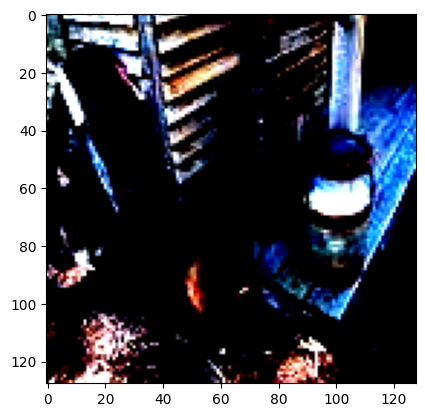

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mammal 1


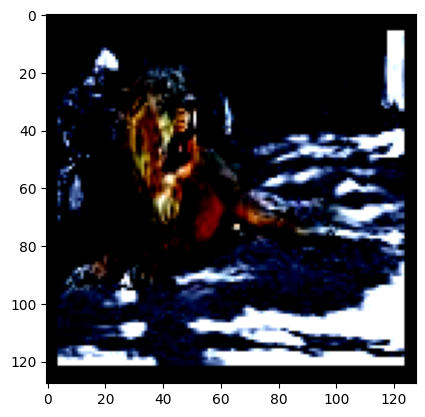

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GeologicalFormation 2


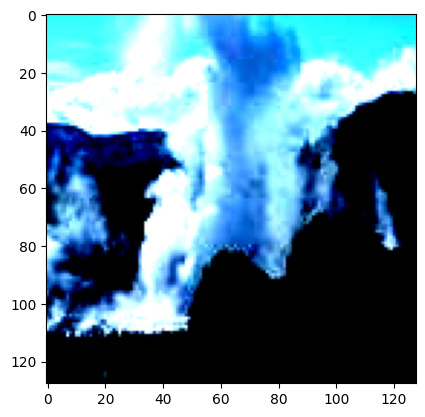

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GeologicalFormation 3


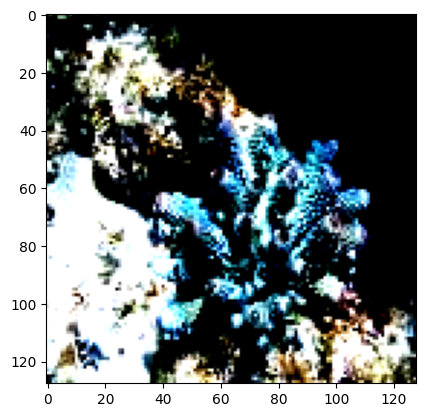

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Food 4


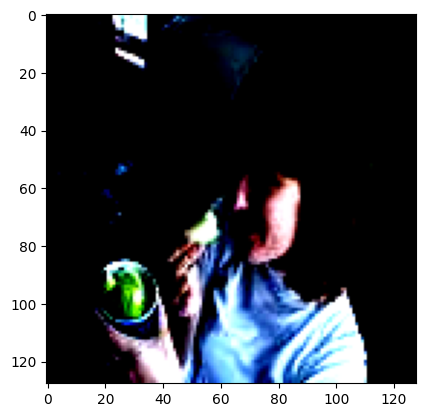

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fish 5


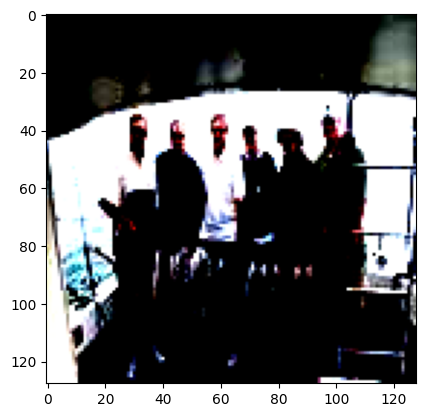

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Furniture 6


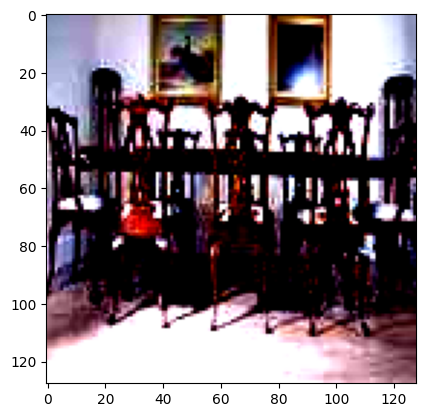

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Container 7


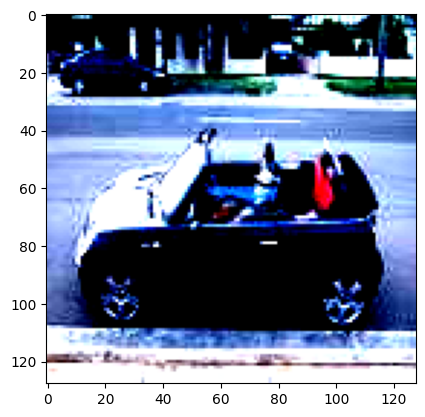

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Vehicle 8


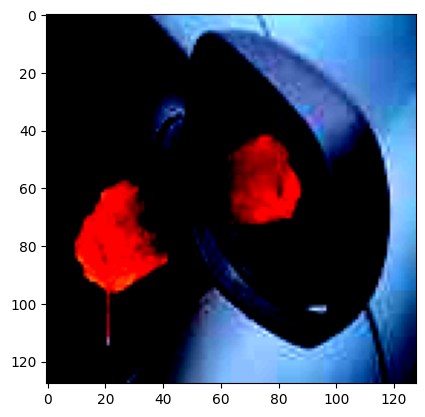

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Furniture 9


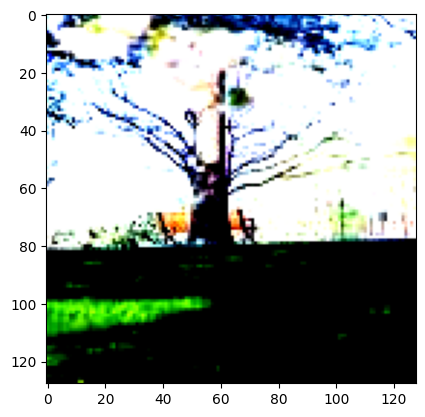

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Structure 10


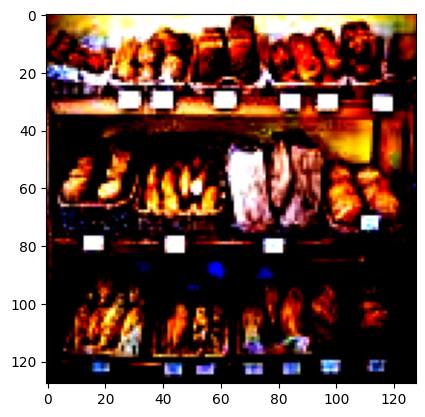

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Utensil 11


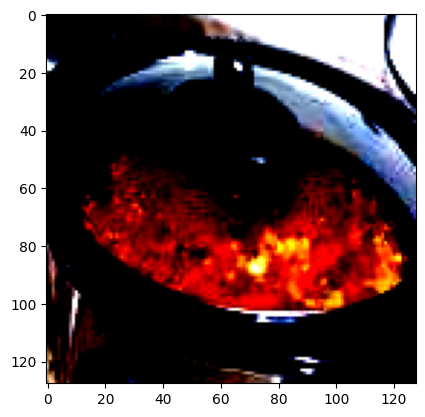

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plant 12


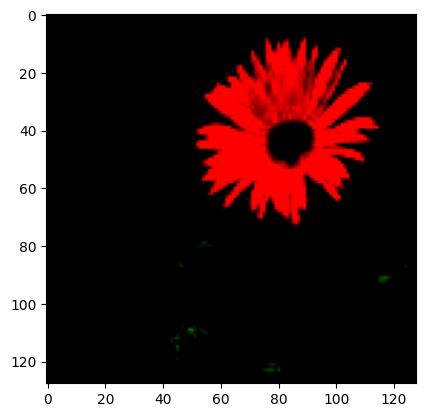

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Vehicle 13


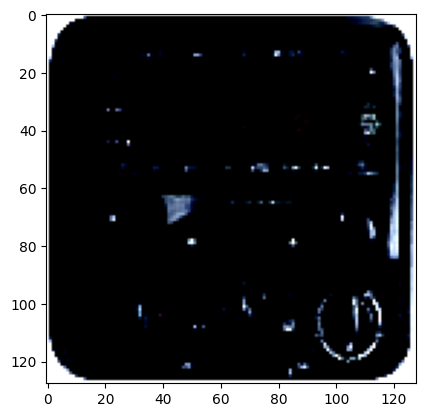

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MusicalInstrument 14


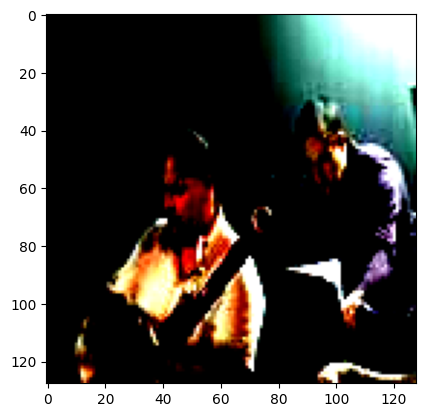

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Container 15


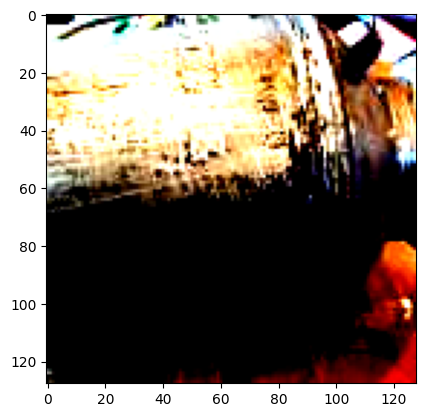

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SportsEquipment 16


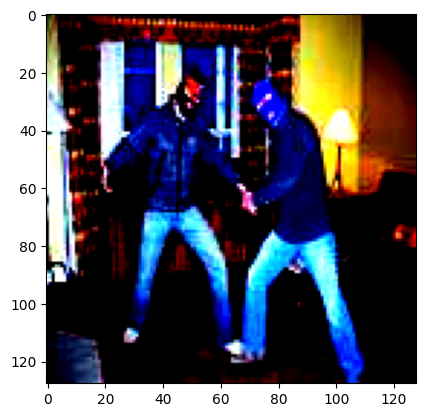

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Food 17


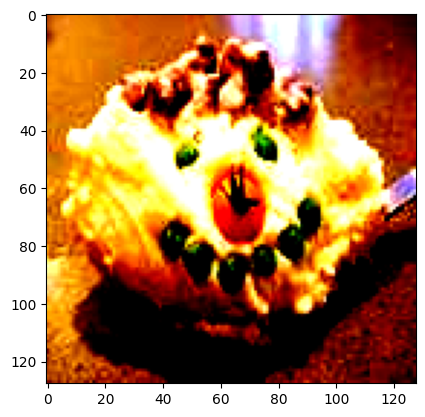

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fish 18


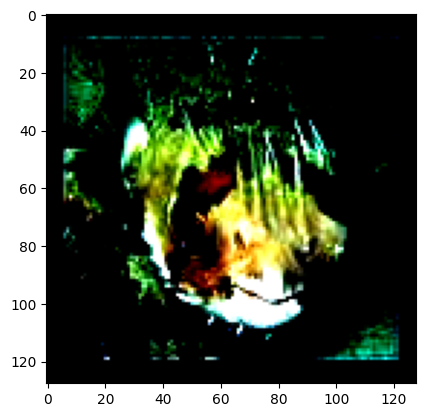

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GeologicalFormation 19


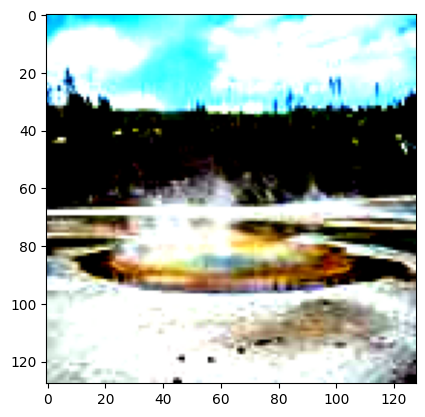

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clothing 20


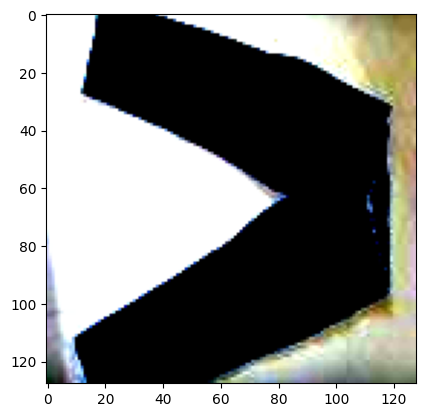

In [6]:
from matplotlib import pyplot as plt

name2label = json.load(open(f"{data_path}/class_name.json"))
label2name = {v:k for k, v in name2label.items()}

for idx, (images, labels) in enumerate(train_data):

    if idx > 20:
      break

    print(label2name[labels], idx)
    plt.imshow(images.permute(1, 2, 0))
    plt.show()


# Model

In [7]:
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # 폴더가 없으면 생성, 있으면 무시

In [8]:
class EarlyStopping:
    def __init__(self, patience=None, verbose=False, delta=0, base_path='Checkpoint', save_path='./'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.base_path = base_path
        self.save_path = save_path

    def step(self, val_loss, model, optimizer, scheduler, scaler, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler, scaler, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler, scaler, epoch)
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, val_loss, model, optimizer, scheduler, scaler, epoch):
        ''' 검증 손실이 감소하면 모델을 저장합니다. '''
        checkpoint_path = os.path.join(self.save_path, f"{self.base_path}_Best_{epoch+1}.pt")  # 경로 결합
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict' : scaler.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss
        }
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model to {checkpoint_path} ...')
        torch.save(checkpoint, checkpoint_path)
        self.val_loss_min = val_loss

In [9]:
# ResNet

def conv3x3(in_planes, out_planes, stride = 1, dilation = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride = 1,
        downsample = None,
        norm_layer = nn.BatchNorm2d,
    ):
        super().__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        # self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=5, stride=1, padding=2)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()
        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * block.expansion, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                self._norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, self._norm_layer)]
        self.inplanes = planes * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=self._norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def _resnet(block, layers, num_classes,):
    model = ResNet(block, layers, num_classes=num_classes)
    return model

In [9]:
# ConvNeXt-Tiny

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.GroupNorm(1, dim)  # NHWC → NCHW 대응
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.act = nn.GELU()
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)).view(1, dim, 1, 1), requires_grad=True)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma * x
        return x + shortcut


class ConvNeXtTiny128(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()

        dims = [96, 192, 384, 768]
        depths = [3, 3, 9, 3]

        self.downsample_layers = nn.ModuleList()
        self.downsample_layers.append(
            nn.Sequential(
                nn.Conv2d(3, dims[0], kernel_size=4, stride=4),
                nn.GroupNorm(1, dims[0])
            )
        )
        for i in range(3):
            self.downsample_layers.append(
                nn.Sequential(
                    nn.GroupNorm(1, dims[i]),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
                )
            )

        self.stages = nn.ModuleList()
        for i in range(4):
            stage = nn.Sequential(*[ConvNeXtBlock(dim=dims[i]) for _ in range(depths[i])])
            self.stages.append(stage)

        self.norm = nn.GroupNorm(1, dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        x = x.mean([-2, -1])  # GAP
        x = self.norm(x.unsqueeze(-1).unsqueeze(-1)).squeeze(-1).squeeze(-1)  # GroupNorm expects 4D
        x = self.head(x)
        return x

In [10]:
import copy

class EMA:
    def __init__(self, model, decay):
        self.ema_model = copy.deepcopy(model)
        self.decay = decay
        self.ema_model.eval()

        for param in self.ema_model.parameters():
            param.requires_grad_(False)

    def update(self, model):
        with torch.no_grad():
            msd = model.state_dict()
            for k, ema_v in self.ema_model.state_dict().items():
                model_v = msd[k].detach()
                ema_v.copy_(ema_v * self.decay + (1. - self.decay) * model_v)

    def forward(self, x):
        return self.ema_model(x)

    def to(self, device):
        self.ema_model.to(device)

    def state_dict(self):
        return self.ema_model.state_dict()

    def load_state_dict(self, state_dict):
        self.ema_model.load_state_dict(state_dict)


In [11]:
def apply_cutmix(images, labels, alpha=1.0):
    '''이미지와 라벨에 CutMix를 적용한 결과를 반환'''
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(images.size(0)).to(images.device)
    target_a = labels
    target_b = labels[rand_index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size(-1) * images.size(-2)))

    return images, target_a, target_b, lam


def rand_bbox(size, lam):
    '''CutMix 적용할 bbox 생성'''
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # center location
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def apply_mixup(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(images.size(0)).to(images.device)
    mixed_images = lam * images + (1 - lam) * images[rand_index]
    labels_a = labels
    labels_b = labels[rand_index]
    return mixed_images, labels_a, labels_b, lam


In [12]:
def load_checkpoint(model, optimizer, scheduler, scaler, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # 다음 에폭부터 시작
    val_loss_min = checkpoint['val_loss']

    print(f"=> Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch})")
    return model, optimizer, scheduler, scaler, start_epoch, val_loss_min

## 학습 중간에 끊긴경우, pt파일불러와 재시작

In [13]:
resume = False  # 재시작 여부
checkpoint_file = r'F:\999\AI_Competition\02_21classes\checkpoints\ConvNeXt-Tiny_EMA_Best_15.pt'

In [14]:
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = ConvNeXtTiny128(num_classes=21).to(device)
# model = _resnet(Bottleneck, [3, 4, 6, 3], num_classes=21).to(device)
model = _resnet(BasicBlock, [3, 4, 6, 3], num_classes=21).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# AdamW Optimizer 적용
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

scaler = GradScaler()

early_stopping = EarlyStopping(patience=30, verbose=True, base_path="ResNet34_EMA", save_path='./checkpoints')


warmup_epochs = 5
num_epochs = 300
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.3,
    anneal_strategy='cos',
    final_div_factor=1e4
)

alpha = 1.0
cutmix_prob = 0.3
mixup_prob = 0.3

# 초기화
ema = EMA(model, decay=0.999)
ema.to(device)

if resume:
    resnet_model, optimizer, scheduler, scaler, start_epoch, val_loss_min = load_checkpoint(
        model, optimizer, scheduler, scaler, checkpoint_file, device
    )
    start_epoch = 15
    val_loss_min = np.Inf
    # val_loss_min 수동 세팅
    early_stopping.val_loss_min = val_loss_min
    early_stopping.best_score = -val_loss_min
else:
    start_epoch = 0


for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    if epoch < 20:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        cutmix_prob, mixup_prob = 0.0, 0.0
    else:
        criterion = nn.CrossEntropyLoss()
        cutmix_prob, mixup_prob = 0.2, 0.1

    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)

        r = np.random.rand()
        optimizer.zero_grad()

        with autocast():
            if r < cutmix_prob:
                images, labels_a, labels_b, lam = apply_cutmix(images, labels, alpha)
                outputs = model(images)
                loss = criterion(outputs, labels_a) * lam + criterion(outputs, labels_b) * (1 - lam)

            elif r < cutmix_prob + mixup_prob:
                images, labels_a, labels_b, lam = apply_mixup(images, labels, alpha)
                outputs = model(images)
                loss = criterion(outputs, labels_a) * lam + criterion(outputs, labels_b) * (1 - lam)

            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

        # loss.backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        ema.update(model)

        total_loss += loss.item()
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(total_loss / (i+1),4)}')


    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        with autocast():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                # outputs = model(images)
                outputs = ema.ema_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # print(f'Accuracy of the model on the test images: {100 * correct / total} %')

    avg_val_loss = val_loss / len(val_loader)
    acc = 100 * correct / total
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {acc:.2f}%')

    # should_stop = early_stopping.step(avg_val_loss, model, optimizer, scheduler, scaler=scaler, epoch=epoch)
    should_stop = early_stopping.step(
        avg_val_loss,
        ema.ema_model,
        optimizer,
        scheduler,
        scaler=scaler,
        epoch=epoch
    ) if epoch >= warmup_epochs else False
    if should_stop:
        print("Early stopping triggered.")
        break

Epoch [1/300], Loss: 2.6997: 100%|██████████| 2068/2068 [18:40<00:00,  1.85it/s]


Validation Loss: 3.0820, Accuracy: 9.44%


Epoch [2/300], Loss: 2.4082: 100%|██████████| 2068/2068 [10:41<00:00,  3.23it/s]


Validation Loss: 2.3923, Accuracy: 32.00%


Epoch [3/300], Loss: 2.2389: 100%|██████████| 2068/2068 [10:46<00:00,  3.20it/s]


Validation Loss: 2.1081, Accuracy: 42.14%


Epoch [4/300], Loss: 2.0932: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.9538, Accuracy: 48.30%


Epoch [5/300], Loss: 1.9684: 100%|██████████| 2068/2068 [10:38<00:00,  3.24it/s]


Validation Loss: 1.8366, Accuracy: 52.90%


Epoch [6/300], Loss: 1.8599: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.7453, Accuracy: 56.48%
Validation loss decreased (inf --> 1.745263).  Saving model to ./checkpoints\ResNet34_EMA_Best_6.pt ...


Epoch [7/300], Loss: 1.7638: 100%|██████████| 2068/2068 [10:42<00:00,  3.22it/s]


Validation Loss: 1.6781, Accuracy: 59.31%
Validation loss decreased (1.745263 --> 1.678088).  Saving model to ./checkpoints\ResNet34_EMA_Best_7.pt ...


Epoch [8/300], Loss: 1.6734: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.6300, Accuracy: 61.39%
Validation loss decreased (1.678088 --> 1.630008).  Saving model to ./checkpoints\ResNet34_EMA_Best_8.pt ...


Epoch [9/300], Loss: 1.5854: 100%|██████████| 2068/2068 [10:43<00:00,  3.21it/s]


Validation Loss: 1.5996, Accuracy: 63.03%
Validation loss decreased (1.630008 --> 1.599580).  Saving model to ./checkpoints\ResNet34_EMA_Best_9.pt ...


Epoch [10/300], Loss: 1.4969: 100%|██████████| 2068/2068 [10:45<00:00,  3.20it/s]


Validation Loss: 1.5822, Accuracy: 63.74%
Validation loss decreased (1.599580 --> 1.582154).  Saving model to ./checkpoints\ResNet34_EMA_Best_10.pt ...


Epoch [11/300], Loss: 1.4089: 100%|██████████| 2068/2068 [10:43<00:00,  3.21it/s]


Validation Loss: 1.5840, Accuracy: 63.56%
EarlyStopping counter: 1 out of 30


Epoch [12/300], Loss: 1.3229: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.5976, Accuracy: 63.70%
EarlyStopping counter: 2 out of 30


Epoch [13/300], Loss: 1.2326: 100%|██████████| 2068/2068 [16:42<00:00,  2.06it/s]


Validation Loss: 1.6215, Accuracy: 62.88%
EarlyStopping counter: 3 out of 30


Epoch [14/300], Loss: 1.1619: 100%|██████████| 2068/2068 [11:41<00:00,  2.95it/s]


Validation Loss: 1.6474, Accuracy: 62.86%
EarlyStopping counter: 4 out of 30


Epoch [15/300], Loss: 1.1011: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.6660, Accuracy: 62.34%
EarlyStopping counter: 5 out of 30


Epoch [16/300], Loss: 1.0675: 100%|██████████| 2068/2068 [10:43<00:00,  3.21it/s]


Validation Loss: 1.6868, Accuracy: 62.49%
EarlyStopping counter: 6 out of 30


Epoch [17/300], Loss: 1.0345: 100%|██████████| 2068/2068 [10:42<00:00,  3.22it/s]


Validation Loss: 1.6949, Accuracy: 62.67%
EarlyStopping counter: 7 out of 30


Epoch [18/300], Loss: 1.0179: 100%|██████████| 2068/2068 [10:42<00:00,  3.22it/s]


Validation Loss: 1.6935, Accuracy: 62.38%
EarlyStopping counter: 8 out of 30


Epoch [19/300], Loss: 1.0054: 100%|██████████| 2068/2068 [10:39<00:00,  3.23it/s]


Validation Loss: 1.6970, Accuracy: 62.91%
EarlyStopping counter: 9 out of 30


Epoch [20/300], Loss: 0.995: 100%|██████████| 2068/2068 [10:37<00:00,  3.24it/s] 


Validation Loss: 1.6952, Accuracy: 62.42%
EarlyStopping counter: 10 out of 30


Epoch [21/300], Loss: 0.9702: 100%|██████████| 2068/2068 [10:42<00:00,  3.22it/s]


Validation Loss: 1.2700, Accuracy: 63.41%
Validation loss decreased (1.582154 --> 1.269966).  Saving model to ./checkpoints\ResNet34_EMA_Best_21.pt ...


Epoch [22/300], Loss: 0.9313: 100%|██████████| 2068/2068 [10:43<00:00,  3.21it/s]


Validation Loss: 1.2733, Accuracy: 63.66%
EarlyStopping counter: 1 out of 30


Epoch [23/300], Loss: 0.8778: 100%|██████████| 2068/2068 [10:35<00:00,  3.25it/s]


Validation Loss: 1.2751, Accuracy: 63.36%
EarlyStopping counter: 2 out of 30


Epoch [24/300], Loss: 0.9024: 100%|██████████| 2068/2068 [10:42<00:00,  3.22it/s]


Validation Loss: 1.2611, Accuracy: 63.80%
Validation loss decreased (1.269966 --> 1.261085).  Saving model to ./checkpoints\ResNet34_EMA_Best_24.pt ...


Epoch [25/300], Loss: 0.9205: 100%|██████████| 2068/2068 [10:35<00:00,  3.26it/s]


Validation Loss: 1.2498, Accuracy: 63.71%
Validation loss decreased (1.261085 --> 1.249771).  Saving model to ./checkpoints\ResNet34_EMA_Best_25.pt ...


Epoch [26/300], Loss: 0.8613: 100%|██████████| 2068/2068 [10:34<00:00,  3.26it/s]


Validation Loss: 1.2428, Accuracy: 63.62%
Validation loss decreased (1.249771 --> 1.242821).  Saving model to ./checkpoints\ResNet34_EMA_Best_26.pt ...


Epoch [27/300], Loss: 0.8563: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s]


Validation Loss: 1.2304, Accuracy: 63.82%
Validation loss decreased (1.242821 --> 1.230401).  Saving model to ./checkpoints\ResNet34_EMA_Best_27.pt ...


Epoch [28/300], Loss: 0.858: 100%|██████████| 2068/2068 [10:44<00:00,  3.21it/s] 


Validation Loss: 1.2218, Accuracy: 64.44%
Validation loss decreased (1.230401 --> 1.221768).  Saving model to ./checkpoints\ResNet34_EMA_Best_28.pt ...


Epoch [29/300], Loss: 0.8323: 100%|██████████| 2068/2068 [10:39<00:00,  3.23it/s]


Validation Loss: 1.2322, Accuracy: 64.76%
EarlyStopping counter: 1 out of 30


Epoch [30/300], Loss: 0.8426: 100%|██████████| 2068/2068 [10:45<00:00,  3.20it/s]


Validation Loss: 1.2282, Accuracy: 64.46%
EarlyStopping counter: 2 out of 30


Epoch [31/300], Loss: 0.8114: 100%|██████████| 2068/2068 [10:41<00:00,  3.22it/s]


Validation Loss: 1.2278, Accuracy: 64.72%
EarlyStopping counter: 3 out of 30


Epoch [32/300], Loss: 0.7816: 100%|██████████| 2068/2068 [10:43<00:00,  3.21it/s]


Validation Loss: 1.2332, Accuracy: 64.34%
EarlyStopping counter: 4 out of 30


Epoch [33/300], Loss: 0.7725: 100%|██████████| 2068/2068 [10:40<00:00,  3.23it/s]


Validation Loss: 1.2243, Accuracy: 65.16%
EarlyStopping counter: 5 out of 30


Epoch [34/300], Loss: 0.7566: 100%|██████████| 2068/2068 [10:45<00:00,  3.21it/s]


Validation Loss: 1.2253, Accuracy: 64.86%
EarlyStopping counter: 6 out of 30


Epoch [35/300], Loss: 0.7665: 100%|██████████| 2068/2068 [10:41<00:00,  3.23it/s]


Validation Loss: 1.2240, Accuracy: 65.36%
EarlyStopping counter: 7 out of 30


Epoch [36/300], Loss: 0.7336: 100%|██████████| 2068/2068 [10:40<00:00,  3.23it/s]


Validation Loss: 1.2206, Accuracy: 64.84%
Validation loss decreased (1.221768 --> 1.220633).  Saving model to ./checkpoints\ResNet34_EMA_Best_36.pt ...


Epoch [37/300], Loss: 0.749: 100%|██████████| 2068/2068 [10:40<00:00,  3.23it/s] 


Validation Loss: 1.2227, Accuracy: 65.09%
EarlyStopping counter: 1 out of 30


Epoch [38/300], Loss: 0.7044: 100%|██████████| 2068/2068 [10:35<00:00,  3.25it/s]


Validation Loss: 1.2110, Accuracy: 65.77%
Validation loss decreased (1.220633 --> 1.210986).  Saving model to ./checkpoints\ResNet34_EMA_Best_38.pt ...


Epoch [39/300], Loss: 0.7063: 100%|██████████| 2068/2068 [10:33<00:00,  3.27it/s]


Validation Loss: 1.2169, Accuracy: 65.25%
EarlyStopping counter: 1 out of 30


Epoch [40/300], Loss: 0.6623: 100%|██████████| 2068/2068 [10:36<00:00,  3.25it/s]


Validation Loss: 1.2218, Accuracy: 65.46%
EarlyStopping counter: 2 out of 30


Epoch [41/300], Loss: 0.6674: 100%|██████████| 2068/2068 [10:32<00:00,  3.27it/s]


Validation Loss: 1.2223, Accuracy: 65.84%
EarlyStopping counter: 3 out of 30


Epoch [42/300], Loss: 0.6465: 100%|██████████| 2068/2068 [10:36<00:00,  3.25it/s]


Validation Loss: 1.2345, Accuracy: 65.77%
EarlyStopping counter: 4 out of 30


Epoch [43/300], Loss: 0.6594: 100%|██████████| 2068/2068 [10:29<00:00,  3.28it/s]


Validation Loss: 1.2116, Accuracy: 65.93%
EarlyStopping counter: 5 out of 30


Epoch [44/300], Loss: 0.6665: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2224, Accuracy: 66.03%
EarlyStopping counter: 6 out of 30


Epoch [45/300], Loss: 0.6334: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2334, Accuracy: 65.73%
EarlyStopping counter: 7 out of 30


Epoch [46/300], Loss: 0.623: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s] 


Validation Loss: 1.2413, Accuracy: 65.97%
EarlyStopping counter: 8 out of 30


Epoch [47/300], Loss: 0.6098: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2592, Accuracy: 65.96%
EarlyStopping counter: 9 out of 30


Epoch [48/300], Loss: 0.6016: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2598, Accuracy: 66.56%
EarlyStopping counter: 10 out of 30


Epoch [49/300], Loss: 0.6231: 100%|██████████| 2068/2068 [10:27<00:00,  3.29it/s]


Validation Loss: 1.2495, Accuracy: 66.08%
EarlyStopping counter: 11 out of 30


Epoch [50/300], Loss: 0.5867: 100%|██████████| 2068/2068 [10:25<00:00,  3.30it/s]


Validation Loss: 1.2479, Accuracy: 66.23%
EarlyStopping counter: 12 out of 30


Epoch [51/300], Loss: 0.6188: 100%|██████████| 2068/2068 [10:25<00:00,  3.30it/s]


Validation Loss: 1.2438, Accuracy: 66.83%
EarlyStopping counter: 13 out of 30


Epoch [52/300], Loss: 0.6079: 100%|██████████| 2068/2068 [10:25<00:00,  3.31it/s]


Validation Loss: 1.2478, Accuracy: 66.11%
EarlyStopping counter: 14 out of 30


Epoch [53/300], Loss: 0.5982: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2576, Accuracy: 66.50%
EarlyStopping counter: 15 out of 30


Epoch [54/300], Loss: 0.5958: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2393, Accuracy: 66.26%
EarlyStopping counter: 16 out of 30


Epoch [55/300], Loss: 0.584: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s] 


Validation Loss: 1.2397, Accuracy: 66.35%
EarlyStopping counter: 17 out of 30


Epoch [56/300], Loss: 0.5766: 100%|██████████| 2068/2068 [13:15<00:00,  2.60it/s]


Validation Loss: 1.2552, Accuracy: 66.67%
EarlyStopping counter: 18 out of 30


Epoch [57/300], Loss: 0.5457: 100%|██████████| 2068/2068 [14:16<00:00,  2.42it/s]


Validation Loss: 1.2656, Accuracy: 66.37%
EarlyStopping counter: 19 out of 30


Epoch [58/300], Loss: 0.53: 100%|██████████| 2068/2068 [10:22<00:00,  3.32it/s]  


Validation Loss: 1.2663, Accuracy: 67.12%
EarlyStopping counter: 20 out of 30


Epoch [59/300], Loss: 0.5634: 100%|██████████| 2068/2068 [10:22<00:00,  3.32it/s]


Validation Loss: 1.2345, Accuracy: 67.09%
EarlyStopping counter: 21 out of 30


Epoch [60/300], Loss: 0.5463: 100%|██████████| 2068/2068 [10:25<00:00,  3.31it/s]


Validation Loss: 1.2397, Accuracy: 66.99%
EarlyStopping counter: 22 out of 30


Epoch [61/300], Loss: 0.527: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s] 


Validation Loss: 1.2626, Accuracy: 66.98%
EarlyStopping counter: 23 out of 30


Epoch [62/300], Loss: 0.5291: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2591, Accuracy: 67.03%
EarlyStopping counter: 24 out of 30


Epoch [63/300], Loss: 0.5354: 100%|██████████| 2068/2068 [10:30<00:00,  3.28it/s]


Validation Loss: 1.2771, Accuracy: 66.34%
EarlyStopping counter: 25 out of 30


Epoch [64/300], Loss: 0.5243: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2665, Accuracy: 66.53%
EarlyStopping counter: 26 out of 30


Epoch [65/300], Loss: 0.5119: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2697, Accuracy: 67.06%
EarlyStopping counter: 27 out of 30


Epoch [66/300], Loss: 0.5289: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2799, Accuracy: 66.49%
EarlyStopping counter: 28 out of 30


Epoch [67/300], Loss: 0.5268: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s]


Validation Loss: 1.2626, Accuracy: 66.04%
EarlyStopping counter: 29 out of 30


Epoch [68/300], Loss: 0.495: 100%|██████████| 2068/2068 [10:23<00:00,  3.32it/s] 


Validation Loss: 1.2845, Accuracy: 66.03%
EarlyStopping counter: 30 out of 30
Early stopping triggered.


# Evaluation

In [ ]:
len(val_loader.dataset)

In [17]:
# 모델 구조 동일하게 정의
model = _resnet(BasicBlock, [3, 4, 6, 3], num_classes=21).to(device)
# model = _resnet(Bottleneck, [3, 4, 6, 3], num_classes=10).to(device)

# 저장된 가중치 불러오기
# ResNet50_EMA_Best_90 # Loss: 0.4080, Accuracy: 86.80%
# ResNet50_EMA_Best_98 # Loss: 0.3957, Accuracy: 86.60%
# ResNet50_EMA_Best_101 # Loss: 0.3877, Accuracy: 87.60%
# ResNet50_EMA_Best_106 # Loss: 0.3744, Accuracy: 88.20%
# ResNet50_EMA_Best_112 # Loss: 0.3691, Accuracy: 87.60%

# ResNet50_EMA_Best_125 # Loss: 0.3668, Accuracy: 88.80%
# ResNet50_EMA_Best_132 # Loss: 0.3624, Accuracy: 87.00%
# ResNet50_EMA_Best_137 # Loss: 0.3527, Accuracy: 89.00%
# ResNet50_EMA_Best_149 # Loss: 0.3479, Accuracy: 89.60%
# ResNet50_EMA_Best_153 # Loss: 0.3382, Accuracy: 89.20%
# ResNet50_EMA_Best_158 # Loss: 0.3285, Accuracy: 89.60%

checkpoint = torch.load('./checkpoints/ResNet34_EMA_Best_38.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# 평가 모드로 전환
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
correct = 0
total = len(val_loader.dataset)

ema.update(model)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ema.ema_model(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')


Accuracy : 66.06802721088435 %


In [19]:
correct = 0
total = len(val_loader.dataset)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')


Accuracy : 65.7687074829932 %


# Make SubmitFile

In [30]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    ema.ema_model.eval()
    with torch.no_grad():

        output = ema.ema_model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

0it [00:00, ?it/s]


In [ ]:
import pandas as pd

# 제출 파일 submission.csv 생성
outputs = {
    'Id': [],
    'Prediction': []
}

for images, id in tqdm(test_loader):
    model.eval()
    with torch.no_grad():

        output = model(images.to(device))
        _, predicted = torch.max(output, 1)
        outputs['Prediction'] += predicted.tolist()
        outputs['Id'] += id

df = pd.DataFrame(outputs)

df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])

In [ ]:
# 제출파일 다운로드
from google.colab import files

file_path = "submission.csv"
files.download(file_path)

# TTA Evaluation

In [25]:
# ema, model 비교

from torchvision.transforms import functional as TF

tta_transforms = [
    lambda x: x,  # 원본 유지
    lambda x: TF.hflip(x)  # 좌우 반전
]

correct = 0
total = len(val_loader.dataset)

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        labels = labels.to(device)
        tta_logits = []

        for t in tta_transforms:
            aug_images = torch.stack([t(img) for img in images])
            aug_images = aug_images.to(device)
            logits = ema.ema_model(aug_images)
            tta_logits.append(logits)

        outputs = torch.stack(tta_logits).mean(0)
        _, predicted = torch.max(outputs, 1)

        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')

100%|██████████| 230/230 [01:12<00:00,  3.16it/s]

Accuracy : 69.52380952380952 %


In [20]:
# TTA가 좌우 반전만 있어서, 여러개 추가

from torchvision.transforms import functional as TF

tta_transforms = [
    lambda x: x,                      # 원본
    lambda x: TF.hflip(x),            # 좌우 반전
    lambda x: TF.vflip(x),            # 상하 반전
    lambda x: TF.rotate(x, 90),       # 90도 회전
]

correct = 0
total = len(val_loader.dataset)

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        labels = labels.to(device)
        tta_logits = []

        for t in tta_transforms:
            aug_images = torch.stack([t(img) for img in images])
            aug_images = aug_images.to(device)
            logits = model(aug_images)
            tta_logits.append(logits)

        outputs = torch.stack(tta_logits).mean(0)
        _, predicted = torch.max(outputs, 1)

        correct += torch.sum((predicted == labels)).item()

print(f'Accuracy : {100 * correct / total} %')

# 여러개 추가시, 성능 저하 결론 : TTA는 좌우 반전만

100%|██████████| 230/230 [03:08<00:00,  1.22it/s]

Accuracy : 65.65986394557824 %


In [39]:
import os
import pandas as pd
from torchvision import transforms
from tqdm import tqdm
from torchvision.transforms import functional as TF

# TTA transform 정의 (원본 + 좌우반전)
# tta_transforms = [
#     transforms.Compose([
#         transforms.ToTensor()
#     ]),
#     transforms.Compose([
#         transforms.RandomHorizontalFlip(p=1.0),
#         transforms.ToTensor()
#     ])
# ]
# 모델 구조 동일하게 정의
model = _resnet(BasicBlock, [3, 4, 6, 3], num_classes=21).to(device)
# model = _resnet(Bottleneck, [3, 4, 6, 3], num_classes=10).to(device)

# 저장된 가중치 불러오기
# ResNet50_EMA_Best_90 # Loss: 0.4080, Accuracy: 86.80%
# ResNet50_EMA_Best_98 # Loss: 0.3957, Accuracy: 86.60%
# ResNet50_EMA_Best_101 # Loss: 0.3877, Accuracy: 87.60%
# ResNet50_EMA_Best_106 # Loss: 0.3744, Accuracy: 88.20%
# ResNet50_EMA_Best_112 # Loss: 0.3691, Accuracy: 87.60%

# ResNet50_EMA_Best_125 # Loss: 0.3668, Accuracy: 88.80%
# ResNet50_EMA_Best_132 # Loss: 0.3624, Accuracy: 87.00%
# ResNet50_EMA_Best_137 # Loss: 0.3527, Accuracy: 89.00%
# ResNet50_EMA_Best_149 # Loss: 0.3479, Accuracy: 89.60%
# ResNet50_EMA_Best_153 # Loss: 0.3382, Accuracy: 89.20%
# ResNet50_EMA_Best_158 # Loss: 0.3285, Accuracy: 89.60%

checkpoint = torch.load('./checkpoints/ResNet34_EMA_Best_38.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# 평가 모드로 전환
model.eval()
ema.update(model)

# 이미지가 Tensor일 때도 동작하는 수동 TTA 정의
tta_transforms = [
    lambda x: x,  # 원본 유지
    lambda x: TF.hflip(x)  # 좌우 반전
]

def predict_with_tta(model, test_loader, tta_transforms, device):
    model.eval()
    outputs = {
        'Id': [],
        'Prediction': []
    }
    
    print(len(test_loader.dataset))

    with torch.no_grad():
        for images, ids in tqdm(test_loader):
            tta_logits = []

            for t in tta_transforms:
                aug_images = torch.stack([t(img) for img in images])  # transform 적용
                aug_images = aug_images.to(device)
                logits = model(aug_images)
                tta_logits.append(logits)

            avg_output = torch.stack(tta_logits).mean(0)  # 평균
            _, predicted = torch.max(avg_output, 1)

            outputs['Prediction'] += predicted.cpu().tolist()
            outputs['Id'] += [os.path.basename(file_id) for file_id in ids]

    return outputs

# EMA 모델로 TTA 예측
outputs = predict_with_tta(ema.ema_model, test_loader, tta_transforms, device)
# outputs = predict_with_tta(model, test_loader, tta_transforms, device)

# 제출 파일 저장
df = pd.DataFrame(outputs)

df.to_csv(r'F:\999\AI_Competition\02_21classes\submission.csv', index=False, columns=['Id', 'Prediction'])
# df.to_csv('submission.csv', index=False, columns=['Id', 'Prediction'])
print(df)
print(device)

5250


100%|██████████| 165/165 [01:28<00:00,  1.87it/s]

               Id  Prediction
0     000000.JPEG          14
1     000001.JPEG           9
2     000002.JPEG          16
3     000003.JPEG           1
4     000004.JPEG           6
...           ...         ...
5245  005245.JPEG           7
5246  005246.JPEG           4
5247  005247.JPEG          19
5248  005248.JPEG          19
5249  005249.JPEG           1

[5250 rows x 2 columns]
cuda


In [ ]:
# 제출파일 다운로드
from google.colab import files

file_path = "submission.csv"
files.download(file_path)